In [5]:
from stable_baselines3 import PPO, SAC, DDPG, A2C
from stable_baselines3.common.env_util import make_vec_env
from env import CropEnv  
from utils import calc_eto_faopm, evaluate_agent, evaluate_agent_single_year, configs 

In [27]:
from aquacrop import IrrigationManagement 
from aquacrop import InitialWaterContent, Crop, Soil, AquaCropModel 

config = configs['nebraska_maize_base']

durations = [] 
yields = [] 

for year in range(700, 1000):
    simyear = year + 1 
    weather_df = config['gendf'][config['gendf']['simyear'] == simyear].drop('simyear',axis=1) 

    # 0 irrigation 
    rainfed = IrrigationManagement(irrigation_method=0) 
    crop = Crop(config['crop'], planting_date=config['planting_date']) 
    soil = Soil(config['soil']) 
    init_wc = InitialWaterContent(wc_type='Pct',value=[70]) 

    simcalyear = config['simcalyear'] 
    month = int(config['planting_date'].split('/')[0]) 
    day = int(config['planting_date'].split('/')[1])
         
    model = AquaCropModel(
        f'{simcalyear}/{month}/{day}',
        f'{simcalyear}/12/31',
        weather_df,
        soil=soil,
        crop=crop, 
        initial_water_content=init_wc,
        irrigation_management=rainfed 
    ) 

    model.run_model(till_termination=True) 
    durations.append(float(model._outputs.final_stats['Harvest Date (Step)'].iloc[0])) 
    yields.append(float(model._outputs.final_stats['Yield potential (tonne/ha)'].iloc[0])) 

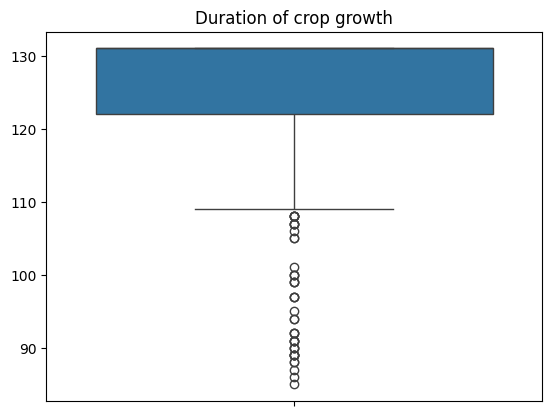

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns 

# pretty box plot of durations
plt.figure()
sns.boxplot(durations)
plt.title('Duration of crop growth')
plt.ylabel('Days')
plt.show() 

In [34]:
np.mean(yields)

11.820495195790004

In [39]:
df

,simyear,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,1,-2.1,-1.2,0.0,0.840868,1995-01-01
1,1,-11.0,18.9,0.0,3.425219,1995-01-02
2,1,-9.0,8.2,0.0,1.950843,1995-01-03
3,1,-5.8,16.5,0.0,2.889402,1995-01-04
4,1,-8.4,-0.8,0.0,1.078832,1995-01-05
...,...,...,...,...,...,...
364995,1000,-22.7,3.0,0.0,1.361588,1995-12-27
364996,1000,-14.4,-2.7,0.0,1.048256,1995-12-28
364997,1000,-11.5,10.5,0.0,2.266705,1995-12-29
364998,1000,-5.9,8.0,0.0,1.791699,1995-12-30


In [52]:
import pandas as pd 
from aquacrop import IrrigationManagement 
from aquacrop import InitialWaterContent, Crop, Soil, AquaCropModel 
import numpy as np 

config = configs['nebraska_maize_base']

df = config['gendf'] 
dates = df[df['simyear']==1]['Date'] 


mean_yields = {}  

for irr_amount in range(10, 100, 10):  
    print(f'Running for {irr_amount} mm') 
     
    durations = [] 
    yields = [] 

    for year in range(700, 1000):
        simyear = year + 1 
        weather_df = config['gendf'][config['gendf']['simyear'] == simyear].drop('simyear',axis=1) 

        schedule_df = pd.DataFrame({'Date':dates, 'Depth':irr_amount})

        irrigate_schedule = IrrigationManagement(irrigation_method=3,schedule=schedule_df) 
        crop = Crop(config['crop'], planting_date=config['planting_date']) 
        soil = Soil(config['soil']) 
        init_wc = InitialWaterContent(wc_type='Pct',value=[70]) 

        simcalyear = config['simcalyear'] 
        month = int(config['planting_date'].split('/')[0]) 
        day = int(config['planting_date'].split('/')[1])
            
        model = AquaCropModel(
            f'{simcalyear}/{month}/{day}',
            f'{simcalyear}/12/31',
            weather_df,
            soil=soil,
            crop=crop, 
            initial_water_content=init_wc,
            irrigation_management=irrigate_schedule 
        ) 

        model.run_model(till_termination=True) 
        print(model._outputs.final_stats) 
        durations.append(float(model._outputs.final_stats['Harvest Date (Step)'].iloc[0])) 
        yields.append(float(model._outputs.final_stats['Yield potential (tonne/ha)'].iloc[0])) 

    mean_yields[irr_amount] = yields 

Running for 10 mm
   Season crop Type Harvest Date (YYYY/MM/DD)  Harvest Date (Step)  \
0       0     Maize                1995-09-10                  131   

   Dry yield (tonne/ha)  Fresh yield (tonne/ha)  Yield potential (tonne/ha)  \
0              7.148155               71.481545                   13.605206   

   Seasonal irrigation (mm)  
0                         0  
   Season crop Type Harvest Date (YYYY/MM/DD)  Harvest Date (Step)  \
0       0     Maize                1995-09-10                  131   

   Dry yield (tonne/ha)  Fresh yield (tonne/ha)  Yield potential (tonne/ha)  \
0             12.228136               122.28136                   13.685009   

   Seasonal irrigation (mm)  
0                         0  
   Season crop Type Harvest Date (YYYY/MM/DD)  Harvest Date (Step)  \
0       0     Maize                1995-08-15                  105   

   Dry yield (tonne/ha)  Fresh yield (tonne/ha)  Yield potential (tonne/ha)  \
0              3.606198               36.0

Text(0.5, 1.0, 'Yield potential for different irrigation amounts')

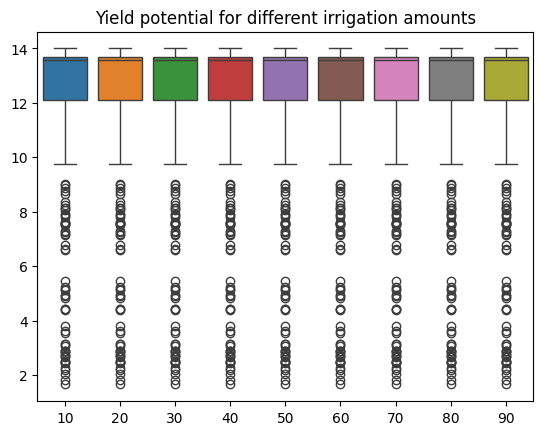

In [57]:
# for each in mean_yields, do box plot, all in one figure 

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.boxplot(data=pd.DataFrame(mean_yields))
plt.title('Yield potential for different irrigation amounts')


In [58]:
schedule_df

,Date,Depth
0,1995-01-01,90
1,1995-01-02,90
2,1995-01-03,90
3,1995-01-04,90
4,1995-01-05,90
...,...,...
360,1995-12-27,90
361,1995-12-28,90
362,1995-12-29,90
363,1995-12-30,90


In [51]:
yields

[13.605206238873444,
 13.685008753497272,
 6.613806744980626,
 13.954344329113075,
 13.68096022397793,
 7.5667135295471,
 8.851479794390714,
 13.61971914088336,
 13.705417562268643,
 13.72535035621171,
 11.450484635563202,
 2.7235309206379505,
 13.601020243346149,
 2.035483930763708,
 13.356426005537065,
 13.74565181460314,
 2.683447419780751,
 13.426011141804103,
 13.638437570343099,
 13.425431354316746,
 2.4992336499989016,
 10.776315791872943,
 13.693736872578166,
 13.809544240311084,
 13.617788052836895,
 9.776568800385634,
 13.749942223308429,
 13.48370662995732,
 13.562653485940475,
 13.57793775778128,
 13.637414147717763,
 13.771232216684608,
 13.505037394461443,
 13.71585573285036,
 13.64669545220266,
 13.79098833128566,
 13.677861073760937,
 13.375352782604692,
 13.744133093280727,
 13.396586723735847,
 13.535195079905222,
 2.817865396707032,
 13.14618590869362,
 13.8321414724619,
 13.600755916622271,
 3.802847322105106,
 13.46260649746672,
 13.714716214387355,
 8.255026436058

In [45]:
mean_yields

{0: 11.820495195790004,
 10: 11.820495195790004,
 20: 11.820495195790004,
 30: 11.820495195790004,
 40: 11.820495195790004,
 50: 11.820495195790004,
 60: 11.820495195790004,
 70: 11.820495195790004,
 80: 11.820495195790004,
 90: 11.820495195790004}

In [15]:
obs = env.reset() 
i = 0 
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action) 
    i += 1 

i 

403.6673387951482


19

In [16]:
model = A2C("MlpPolicy", env, n_steps=18)

In [25]:
# filter where  between 05-01 and 09-01 

df = env.gendf
perp = df[(df['Date'] > '1995-05-01') & (df['Date'] < '1995-09-01')] 

NameError: name 'env' is not defined

In [32]:
env.model.weather_df.to_numpy()[0:3,0].mean(axis=0).flatten()

array([4.6])

(array([1.11734e+05, 5.50100e+03, 2.72800e+03, 9.60000e+02, 4.77000e+02,
        2.24000e+02, 1.25000e+02, 1.23000e+02, 1.04000e+02, 2.40000e+01]),
 array([ 0. ,  8.5, 17. , 25.5, 34. , 42.5, 51. , 59.5, 68. , 76.5, 85. ]),
 <BarContainer object of 10 artists>)

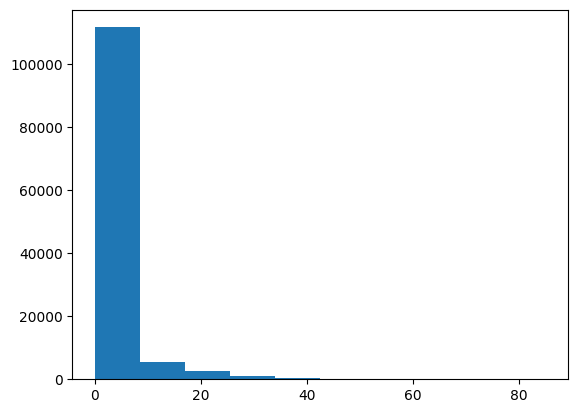

In [26]:
import matplotlib.pyplot as plt 

plt.hist(perp['Precipitation']) 

In [17]:
#Parallel environments

model = PPO("MlpPolicy", env, n_steps=500)
#model = PPO.load("ppo")
#model.set_env(env)
model.learn(total_timesteps=250000, progress_bar=True)
model.save(".saved_model/ppo_500")

Output()

/opt/anaconda3/envs/rl-agri/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/opt/anaconda3/envs/rl-agri/lib/python3.9/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 500`, after every 7 untruncated mini-batches, there will be a truncated mini-batch of size 52
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=500 and n_envs=1)
  warnings.warn(


Traceback (most recent call last):

File "/opt/anaconda3/envs/rl-agri/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__

self.close()

File "/opt/anaconda3/envs/rl-agri/lib/python3.9/site-packages/tqdm/std.py", line 1277, in close

if self.last_print_t < self.start_t + self.delay:

AttributeError: 'tqdm' object has no attribute 'last_print_t'

In [33]:
env.model._output

AttributeError: 'AquaCropModel' object has no attribute '_output'

In [7]:
#Parallel environments

model = SAC("MlpPolicy", env, train_freq=500)
#model = PPO.load("ppo")
#model.set_env(env)
model.learn(total_timesteps=250000, progress_bar=True)
model.save(".saved_model/ppo_500")

Output()

/opt/anaconda3/envs/rl-agri/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


KeyboardInterrupt: 

In [3]:
model = DDPG("MlpPolicy", env)
#model = PPO.load("ppo")
#model.set_env(env)
model.learn(total_timesteps=250000, progress_bar=True)
model.save(".saved_model/ddpg")

/opt/anaconda3/envs/rl-agri/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Output()

In [9]:
model = A2C("MlpPolicy", env)
model.learn(total_timesteps=250000, progress_bar=True)
model.save(".saved_model/a2c")

Output()

/opt/anaconda3/envs/rl-agri/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [18]:
model = PPO.load(".saved_model/ppo_500")
evaluate_agent(model, CropEnv, config, stable_baselines=True)

100%|██████████| 100/100 [00:06<00:00, 16.12it/s]


(-0.07612373086856326, -0.07694350728858997)